# Project Description

Overview of the project:
1. The dataset contains 4 animal categories. Each category has around 380 images. Total images being 1514.
2. The images are acquired through Google Images mostly and also through web scraping.
3. Each image is then annotated with the program "LabelImg" which is avaialble on Github (https://github.com/heartexlabs/labelImg)
4. The annotation is done in the "YOLO" format. Each image has a corresponding text file with the same name that contains the annotation. The format of the annotation is that the first character represents the class in number from 0-9 and then follows the four coordinates of the bounding box which is drawn manually during the annotation process.
5. The model used is a CNN model which is created from scratch.

**Other Notes:**
1. There is no need to add the dataset manually to this notebook. The data will be loaded using "gdown" from my Google Drive. This is to ensure that the data loads faster because normal uploading to the collab file takes a lot of time.
2. The tensorflow version used here is 2.3.1. The command to install it is in this file.

In [ ]:
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
!pip install tensorflow===2.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 KB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 30.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
   

In [ ]:
# Download my custom dataset to this session storage.
!gdown 1iCxJJf_JxuYS8htd_6OJsR_83dAERCX2

Downloading...
From: https://drive.google.com/uc?id=1iCxJJf_JxuYS8htd_6OJsR_83dAERCX2
To: /content/custom_dataset.zip
100% 469M/469M [00:04<00:00, 97.3MB/s]


In [ ]:
!unzip custom_dataset.zip -d animals

In [ ]:
# The project uses tensorflow for deep learning
# Import required libraries

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
import re
import os
import glob
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import*
import matplotlib.pyplot as plt
from sklearn.model_selection import*
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.image as mpimg

from sklearn.linear_model import*
from sklearn.preprocessing import*
from sklearn.ensemble import*
from sklearn.neighbors import*
from sklearn import svm
from sklearn.naive_bayes import*
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras import Sequential

from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix

print("Tensorflow Version: ", tf.__version__)

Tensorflow Version:  2.3.1


In [ ]:
print("The following are the folders containing the data (images + annotations):\n")
for i in os.listdir('animals/'):
    print('animals/'+i)

The following are the folders containing the data (images + annotations):

animals/buffalo
animals/zebra
animals/elephant
animals/rhino


In [ ]:
print("The following is an example of an annotation:\n")
data=open('animals/zebra/017.txt')
data.read()

The following is an example of an annotation:



'3 0.500000 0.606250 0.162500 0.391667\n3 0.652344 0.520833 0.457813 0.587500\n'

Plotting a few images from the dataset as an example:

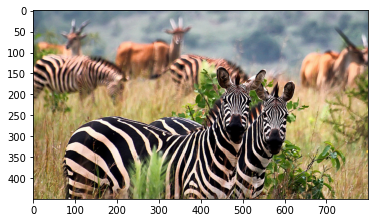

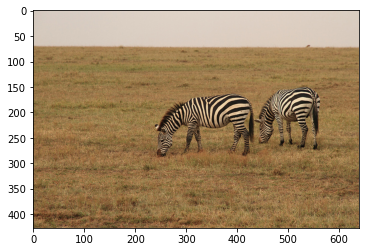

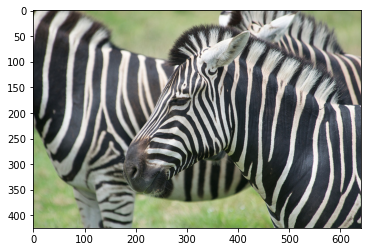

In [ ]:
image_total = 0
for image_counter in os.listdir('animals/zebra/'):
  # Choose files that are .jpg only
  if image_counter[-3:] !='txt':
    img=mpimg.imread('animals/zebra/'+image_counter)
    plt.imshow(img)
    plt.show()
    image_total += 1
  if image_total == 3:
    break

Define Training and Testing Data

In [ ]:
# We need to define the labels in the same order they were annotated in LabelImg

def data_processor(path_to_animal, label):
  dataframe=[]
  label_array=[]

  for i in os.listdir(path_to_animal):
    if i[-3:] !='txt':
      img=mpimg.imread(path_to_animal+i)
      img=resize(img,(128,128),anti_aliasing=True)
      # In case the image is greyscale, convert it to RGB [3 channel greyscale image]
      if img.shape == (128,128):
        single_channel = img.reshape(128, 128, 1)
        img = np.concatenate([single_channel,single_channel,single_channel], axis = -1)
      # In case image is RGBA, drop the alpha channel
      elif img.shape == (128,128,4):
        img = img[:,:,:3]
      # Now we flatten out the RGB image
      tensor=img.reshape(49152)
      dataframe.append(tensor)
  for i in range(len(dataframe)):
    label_array.append(label)
  dataframe=pd.DataFrame(dataframe)
  label_array=pd.DataFrame({'label':label_array})
  data=pd.concat([label_array,dataframe],axis=1)
  X=data.drop('label',1)
  y=data['label']
  return X,y

X,y = data_processor("animals/buffalo/", 0)
# Split the training and testing data into 85% and 15% respectively. Shuffle is applied by default.
xtr1,xts1,ytr1,yts1=train_test_split(X,y,test_size=0.15,random_state=0)

<ipython-input-10-b0705a56772d>:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X=data.drop('label',1)


In [ ]:
print("Shape of Training and Testing Data Sets:")
xtr1.shape,xts1.shape,ytr1.shape,yts1.shape

Shape of Training and Testing Data Sets:


((319, 49152), (57, 49152), (319,), (57,))

In [ ]:
xtr1.head()

,0,1,2,3,4,5,6,7,8,9,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
20,0.643627,0.681373,0.695588,0.700980,0.751471,0.782353,0.647549,0.682353,0.670098,0.717647,...,0.559314,0.842157,0.789706,0.651471,0.780392,0.743627,0.588235,0.802941,0.772549,0.591176
90,0.385600,0.404550,0.270902,0.475797,0.480691,0.349334,0.546745,0.549020,0.395435,0.586933,...,0.552282,0.702290,0.605882,0.451310,0.737898,0.638557,0.499341,0.685302,0.579749,0.444455
141,0.366238,0.307414,0.225061,0.372549,0.314874,0.232521,0.358012,0.313128,0.228002,0.358012,...,0.409635,0.759635,0.594547,0.407843,0.750812,0.582184,0.405331,0.763343,0.594715,0.418244
225,0.624862,0.713725,0.409176,0.635294,0.703217,0.436550,0.658824,0.722825,0.457491,0.622350,...,0.423683,0.658824,0.695450,0.426118,0.665411,0.711137,0.450980,0.658900,0.709881,0.443214
370,0.187577,0.199012,0.143137,0.275153,0.317961,0.249004,0.538228,0.569271,0.471546,0.430086,...,0.546415,0.751639,0.671247,0.509490,0.733349,0.665694,0.501976,0.783012,0.700000,0.553271


In [ ]:
# Create all other Training and Testing sets

X,y = data_processor("animals/elephant/", 1)
xtr2,xts2,ytr2,yts2=train_test_split(X,y,test_size=0.15,random_state=0)

X,y = data_processor("animals/rhino/", 2)
xtr3,xts3,ytr3,yts3=train_test_split(X,y,test_size=0.15,random_state=0)

X,y = data_processor("animals/zebra/", 3)
xtr4,xts4,ytr4,yts4=train_test_split(X,y,test_size=0.15,random_state=0)

<ipython-input-10-b0705a56772d>:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X=data.drop('label',1)


**Creating the Dataframe:**
1. Concatenate all the separate dataframes into Training and Testing parts
2. Reshuffle the Training and Testing data
3. Produce Feature set and Target value

In [ ]:
X_train=pd.concat([xtr1,xtr2,xtr3,xtr4],axis=0)
y_train=pd.concat([ytr1,ytr2,ytr3,ytr4],axis=0)

X_test=pd.concat([xts1,xts2,xts3,xts4],axis=0)
y_test=pd.concat([yts1,yts2,yts3,yts4],axis=0)

In [ ]:
train=pd.concat([X_train,y_train],axis=1)
train=train.sample(frac=1)
test=pd.concat([X_test,y_test],axis=1)
test.sample(frac=1)

X_train=train.drop('label',1)
y_train=train['label']
X_test=test.drop('label',1)
y_test=test['label']

<ipython-input-15-e8a3c8d45f55>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train=train.drop('label',1)
<ipython-input-15-e8a3c8d45f55>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test=test.drop('label',1)


In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1276, 49152), (228, 49152), (1276,), (228,))

In [ ]:
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1276, 49152), (228, 49152), (1276,), (228,))

In [ ]:
X_train=X_train.reshape(1276,128,128,3)
X_test=X_test.reshape(228,128,128,3)

In [ ]:
# Initialize a name array for all the animals corresponding to class values in the dataset.
# The names will be printed when testing the data

animal_names_ordered=['buffalo','elephant','rhino','zebra']

In [ ]:
# Change the Target Value format to int64
y_train=y_train.astype('int64')
y_test=y_test.astype('int64')

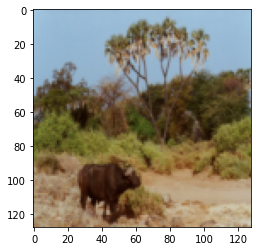

buffalo


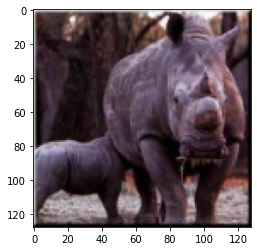

rhino


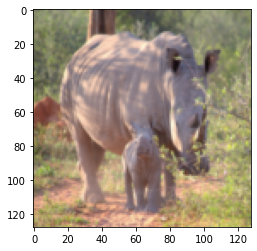

rhino


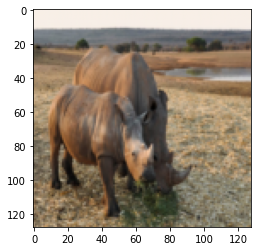

rhino


In [ ]:
# Plot some images from the dataset to check if the dataframe is alright

for i in range(4):
  plt.imshow(X_train[i])
  plt.show()
  print(animal_names_ordered[y_train[i]])

In [ ]:
# Reshape the actual data because we are feeding the data into Convnet layers

y_train=y_train.reshape(1276,1)
y_test=y_test.reshape(228,1)

**Model Generation :**

1. First we generate a CNN model with a Kernel Size of (3,3) and fit the data
2. Then we change the network "setting" to a kernel size of (4, 4) and fit the data again to create a different solution.
3. Finally we evaluate the differences between the two solutions and find the better one

In [ ]:
model_3_3=Sequential()

model_3_3.add(Conv2D(64,activation='relu',kernel_size=(3,3),input_shape=X_train[0].shape))
model_3_3.add(Dense(64,activation='relu'))
model_3_3.add(Dropout(0.25))
model_3_3.add(Dense(64,activation='relu'))
model_3_3.add(Dropout(0.5))
model_3_3.add(Flatten())
model_3_3.add(Dense(128,activation='relu'))
model_3_3.add(Dense(4,activation='softmax'))

In [ ]:
model_3_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
dense (Dense)                (None, 126, 126, 64)      4160      
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 64)      0         
_________________________________________________________________
dense_1 (Dense)              (None, 126, 126, 64)      4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 126, 126, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1016064)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1

In [ ]:
model_3_3.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Here we fit the model. We use test data as validation. We use a batch size of 20 which is lower than usual but gives a better accuracy for our model considering the relatively small dataset. The model can be saved on Google Drive if given access.

In [ ]:
hist_3_3 = model_3_3.fit(X_train,y_train,batch_size=20,epochs=10,verbose=1,validation_data=(X_test,y_test))
# model_3_3.save("/content/drive/MyDrive/3_3_kernel.h5")

Epoch 1/10
64/64 [==============================] - 143s 2s/step - loss: 1.3357 - accuracy: 0.3542 - val_loss: 1.1938 - val_accuracy: 0.5482
Epoch 2/10
64/64 [==============================] - 143s 2s/step - loss: 1.0512 - accuracy: 0.5509 - val_loss: 0.9317 - val_accuracy: 0.6009
Epoch 3/10
64/64 [==============================] - 140s 2s/step - loss: 0.7313 - accuracy: 0.6951 - val_loss: 0.9568 - val_accuracy: 0.5833
Epoch 4/10
64/64 [==============================] - 140s 2s/step - loss: 0.4653 - accuracy: 0.8307 - val_loss: 0.9158 - val_accuracy: 0.5789
Epoch 5/10
64/64 [==============================] - 137s 2s/step - loss: 0.1970 - accuracy: 0.9459 - val_loss: 1.2280 - val_accuracy: 0.6140
Epoch 6/10
64/64 [==============================] - 144s 2s/step - loss: 0.0759 - accuracy: 0.9828 - val_loss: 1.5217 - val_accuracy: 0.5746
Epoch 7/10
64/64 [==============================] - 144s 2s/step - loss: 0.0441 - accuracy: 0.9929 - val_loss: 1.6948 - val_accuracy: 0.5658
Epoch 8/10
64

The model with Kernel Size (3,3) overfitted after the second Epoch. We now plot the model accuracy and loss graphs for testing and validation sets.

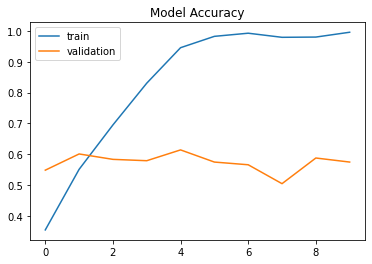

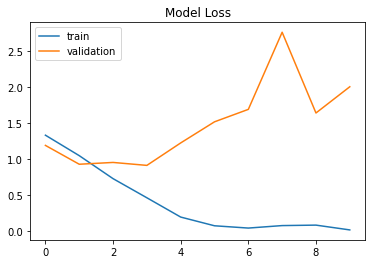

In [ ]:
plt.title('Model Accuracy')
plt.plot(hist_3_3.history['accuracy'],label='train')
plt.plot(hist_3_3.history['val_accuracy'],label='validation')
plt.legend()
plt.show()
plt.title('Model Loss')
plt.plot(hist_3_3.history['loss'],label='train')
plt.plot(hist_3_3.history['val_loss'],label='validation')
plt.legend()
plt.show()

In [ ]:
prediction=model_3_3.predict(X_test)
type(prediction[0])

numpy.ndarray

In [ ]:
# We find the actual prediction with numpy's argmax
tr_pred=model_3_3.predict(X_train)
y1=[]
for i in tr_pred:
  y1.append(np.argmax(i))
ts_pred=model_3_3.predict(X_test)
y2=[]
for i in ts_pred:
  y2.append(np.argmax(i))

**We now generate a Confusion Matrix to see how well our model with kernel (3,3) classified the images**

In [ ]:
for i in range(len(y1)):
  y1[i]=animal_names_ordered[y1[i]]
for i in range(len(y2)):
  y2[i]=animal_names_ordered[y2[i]]

In [ ]:
y_train_3_3=y_train.reshape(1276)
y_test_3_3=y_test.reshape(228)

In [ ]:
y_1=[]
y_2=[]
for i in range(len(y_train)):
  y_1.append(animal_names_ordered[y_train[i]])
for i in range(len(y_test)):
  y_2.append(animal_names_ordered[y_test[i]])

For Training Data:


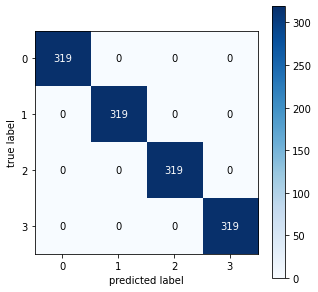

In [ ]:
train_mat=confusion_matrix(y_1,y1)
plot_confusion_matrix(train_mat,figsize=(5,5),colorbar=True)
print("For Training Data:")

For Testing Data:


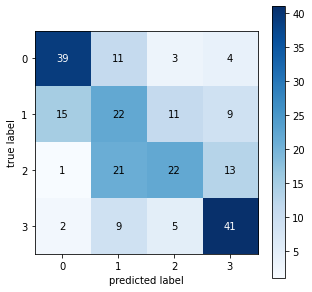

In [ ]:
test_mat=confusion_matrix(y_2,y2)
plot_confusion_matrix(test_mat,figsize=(5,5),colorbar=True)
print("For Testing Data:")

categories = ['buffalo','elephant','rhino','zebra']

We can evaluate the following using the above confusion matrix of the testing data:
1. Most buffalos and zebras were classified correctly
2. Elephants can sometimes be predicted as buffalos
3. Rhinos can be misinterpreted as elephants often, probably because they have similar body color and overall body shape

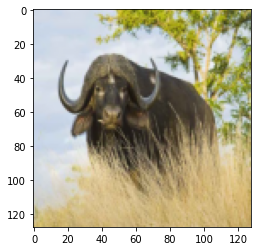

Predicted Label:  buffalo


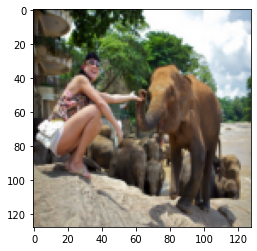

Predicted Label:  elephant


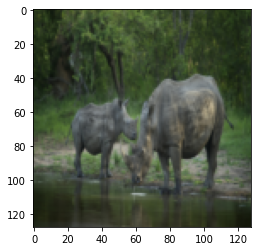

Predicted Label:  zebra


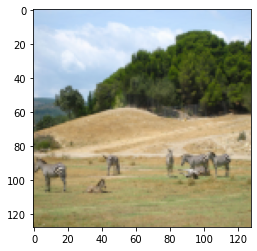

Predicted Label:  zebra


In [ ]:
# We print some results to check the predicted Labels
for i in range(0, 240, 60):
  plt.imshow(X_test[i])
  plt.show()
  print("Predicted Label: ", y2[i])

**Now we try a different solution. We change the Kernel Size of the CNN to (4,4) and evaluate the model.**

In [ ]:
model_4_4=Sequential()

model_4_4.add(Conv2D(64,activation='relu',kernel_size=(4,4),input_shape=X_train[0].shape))
model_4_4.add(Dense(64,activation='relu'))
model_4_4.add(Dropout(0.25))
model_4_4.add(Dense(64,activation='relu'))
model_4_4.add(Dropout(0.5))
model_4_4.add(Flatten())
model_4_4.add(Dense(128,activation='relu'))
model_4_4.add(Dense(4,activation='softmax'))

In [ ]:
model_4_4.summary()
model_4_4.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 125, 125, 64)      3136      
_________________________________________________________________
dense_7 (Dense)              (None, 125, 125, 64)      4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 125, 125, 64)      0         
_________________________________________________________________
dense_8 (Dense)              (None, 125, 125, 64)      4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 125, 125, 64)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1000000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

In [ ]:
hist_4_4 = model_4_4.fit(X_train,y_train,batch_size=20,epochs=15,verbose=1,validation_data=(X_test,y_test))
# model_4_4.save("/content/drive/MyDrive/4_4_kernel.h5")

Epoch 1/15
64/64 [==============================] - 141s 2s/step - loss: 2.9866 - accuracy: 0.3135 - val_loss: 1.3735 - val_accuracy: 0.3202
Epoch 2/15
64/64 [==============================] - 155s 2s/step - loss: 1.3161 - accuracy: 0.4193 - val_loss: 1.2212 - val_accuracy: 0.5658
Epoch 3/15
64/64 [==============================] - 149s 2s/step - loss: 1.1503 - accuracy: 0.4914 - val_loss: 1.1006 - val_accuracy: 0.5658
Epoch 4/15
64/64 [==============================] - 144s 2s/step - loss: 1.0699 - accuracy: 0.5345 - val_loss: 1.0967 - val_accuracy: 0.4956
Epoch 5/15
64/64 [==============================] - 145s 2s/step - loss: 0.9924 - accuracy: 0.5917 - val_loss: 1.0827 - val_accuracy: 0.5439
Epoch 6/15
64/64 [==============================] - 144s 2s/step - loss: 0.9184 - accuracy: 0.6238 - val_loss: 1.0101 - val_accuracy: 0.5789
Epoch 7/15
64/64 [==============================] - 142s 2s/step - loss: 0.7703 - accuracy: 0.7053 - val_loss: 1.0039 - val_accuracy: 0.5789
Epoch 8/15
64

The model with Kernel Size (4,4) overfitted after the thrid Epoch but the validation accuracy is now lower than before. The validation loss ends up being higher as well.

**Therefore, we can say that the model with kernel (3,3) fits better for this classification problem.**

We now plot the accuracy and loss graphs for testing and validation sets.

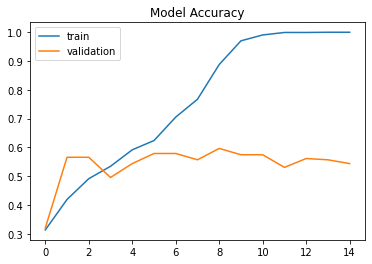

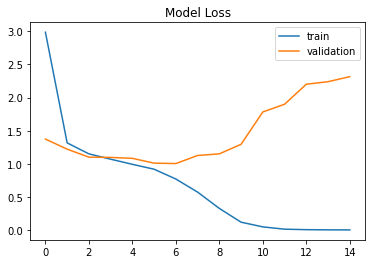

In [ ]:
plt.title('Model Accuracy')
plt.plot(hist_4_4.history['accuracy'],label='train')
plt.plot(hist_4_4.history['val_accuracy'],label='validation')
plt.legend()
plt.show()
plt.title('Model Loss')
plt.plot(hist_4_4.history['loss'],label='train')
plt.plot(hist_4_4.history['val_loss'],label='validation')
plt.legend()
plt.show()

In [ ]:
prediction=model_4_4.predict(X_test)
type(prediction[0])

numpy.ndarray

In [ ]:
# We find the actual prediction with numpy's argmax
tr_pred=model_4_4.predict(X_train)
y1=[]
for i in tr_pred:
  y1.append(np.argmax(i))
ts_pred=model_4_4.predict(X_test)
y2=[]
for i in ts_pred:
  y2.append(np.argmax(i))

**We now generate a Confusion Matrix to see how well our model with kernel (4,4) classified the images**

In [ ]:
for i in range(len(y1)):
  y1[i]=animal_names_ordered[y1[i]]
for i in range(len(y2)):
  y2[i]=animal_names_ordered[y2[i]]

In [ ]:
y_train_4_4=y_train.reshape(1276)
y_test_4_4=y_test.reshape(228)

In [ ]:
y_1=[]
y_2=[]
for i in range(len(y_train)):
  y_1.append(animal_names_ordered[y_train[i]])
for i in range(len(y_test)):
  y_2.append(animal_names_ordered[y_test[i]])

For Testing Data:


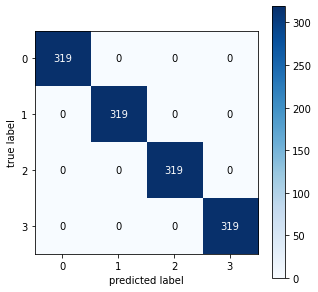

In [ ]:
train_mat=confusion_matrix(y_1,y1)
plot_confusion_matrix(train_mat,figsize=(5,5),colorbar=True)
print("For Testing Data:")

For Training Data:


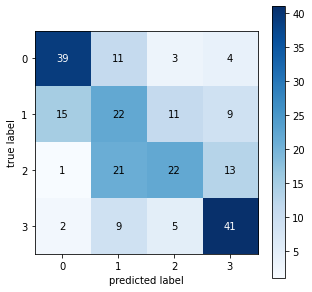

In [ ]:
test_mat=confusion_matrix(y_2,y2)
plot_confusion_matrix(test_mat,figsize=(5,5),colorbar=True)
print("For Training Data:")

The labels predicted are the same as the model with kernel size of (3,3)

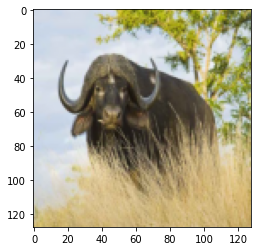

Predicted Label:  buffalo


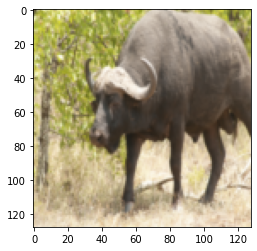

Predicted Label:  buffalo


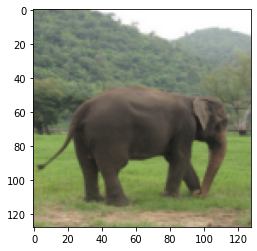

Predicted Label:  rhino


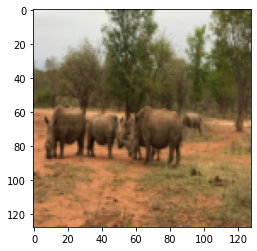

Predicted Label:  rhino


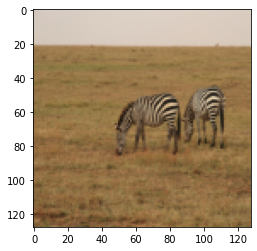

Predicted Label:  zebra


In [ ]:
# We print some results to check the predicted Labels
for i in range(0, 240, 50):
  plt.imshow(X_test[i])
  plt.show()
  print("Predicted Label: ", y2[i])